# Spred sheet processing

Parse a given CSV file and evaluate each cell by these rules:
1. Each cell is an expression in postfix notation. Please refer to the wikipedia page for a full description.
2. Each number or operation will always be separated by one or more spaces.
3. A cell can refer to another cell, via the LETTER NUMBER notation (A2, B4, etc - letters refer to columns, numbers to rows).
4. Support the basic arithmetic operators +, -, *, /

The output will be a CSV file of the same dimensions, where each cell is evaluated to its final value. If any cell is an invalid expression, then for that cell only print #ERR.

For example, the following CSV input:
```
10, 1 3 +, 2 3 -
b1 b2 *, a1, b1 a2 / c1 +
+, 1 2 3, c3
```

Might output something like this:
```
10,4,-1
40,10,-0.9
#ERR,#ERR,#ERR
```

## Approach

A spred sheet is a graph of cells which can consist of multiple sub graphs.



In [1]:
from typing import (
    List,
    Dict,
    Set,
    Tuple,
    Callable,
    Any,
    Optional,
    Union,
)
import os
import sys
import operator
import logging
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import (
    product
)

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

# Read table as dataframe

In [3]:
def load_table(path_to_file: str) -> pd.DataFrame:
    """Load table structure as a dataframe
    Args:
        path_to_file: path to the file
    Returns: dataframe
    """
    df = pd.read_csv(
        path_to_file,
        dtype=str,
        engine="c",
    )
    # Reindex column from 1
    df.index += 1
    return df

In [4]:
# df: pd.DataFrame = load_table("./data/sheet.csv")
df: pd.DataFrame = load_table("./data/example.csv")
df

,a,b,c
1,10,1 3 +,2 3 -
2,b1 b2 *,a1,b1 a2 / c1 +
3,+,1 2 3,c3


In [5]:
COLUMN_NAMES = list(df.columns)
ROW_INDICES = list(df.index)
NUM_COLS = len(COLUMN_NAMES)
NUM_ROWS = len(df.index)

# Parse table as graph

In [6]:
def parse_table_into_graph(table: pd.DataFrame) -> nx.DiGraph:
    """Prase the table cells and generate a graph repreenting cells as nodes.
    Args:
        table: table structure as pandas dataframe
    Returns: NetworkX multi directed graph
    """
    assert isinstance(table, pd.DataFrame) and table.count().sum() > 0
    graph: nx.DiGraph = nx.DiGraph()

    # All the cell names e.g. {"a1", "a2", "b1", "b2"}
    cell_names: Set = {
        f"{column}{row}"
        for column, row in product(df.columns.tolist(), df.index.tolist())
    }

    for column in df.columns:
        for row in df.index:
            current_cell_name: str = f"{column}{row}"
            
            # --------------------------------------------------------------------------------
            # Expression in the cell e.g. "1 3 * 2 /"
            # --------------------------------------------------------------------------------
            cell: str = df.at[row, column]
            expression = " ".join(cell.split())

            # --------------------------------------------------------------------------------
            # References to other cells if any e.g. expression = "1 b1 + c2 *"
            # --------------------------------------------------------------------------------
            references = set(expression.split()) & cell_names
            
            # --------------------------------------------------------------------------------
            # Self refence expression is invalid e.g. "a1 1 +" in the cell a1
            # --------------------------------------------------------------------------------
            value: Optional[float] = None
            validity: bool = True
            if current_cell_name in references:
                value = np.NaN
                validity = False
                logger.error("cell[%s] expression has self reference", current_cell_name, expression)
            
            # --------------------------------------------------------------------------------
            # Edges from the current node to the cells referenced
            # --------------------------------------------------------------------------------
            edges = product([current_cell_name], references)
            graph.add_edges_from(edges)
            
            # --------------------------------------------------------------------------------
            # Node representing the current cell
            # --------------------------------------------------------------------------------
            graph.add_node(
                current_cell_name,
                valid = validity,
                expression=expression,
                value=value,
            )

            
    return graph

In [7]:
sheet = parse_table_into_graph(table=df)
sheet.nodes(data=True)

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File

NodeDataView({'a1': {'valid': True, 'expression': '10', 'value': None}, 'a2': {'valid': True, 'expression': 'b1 b2 *', 'value': None}, 'b1': {'valid': True, 'expression': '1 3 +', 'value': None}, 'b2': {'valid': True, 'expression': 'a1', 'value': None}, 'a3': {'valid': True, 'expression': '+', 'value': None}, 'b3': {'valid': True, 'expression': '1 2 3', 'value': None}, 'c1': {'valid': True, 'expression': '2 3 -', 'value': None}, 'c2': {'valid': True, 'expression': 'b1 a2 / c1 +', 'value': None}, 'c3': {'valid': False, 'expression': 'c3', 'value': nan}})

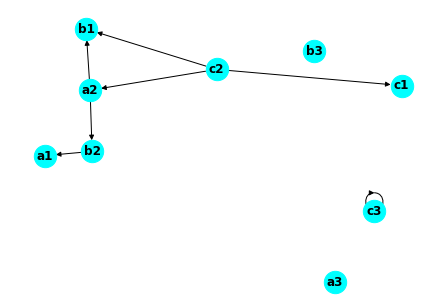

In [8]:
pos = nx.spring_layout(sheet, seed=12)

nx.draw(
    sheet, 
    pos=pos,
    node_size=500,
    node_color="cyan",
    with_labels=True, 
    font_weight='bold'
)

---
# Individual path to process


## Toplogical Graph Sort
Each sub graph in the table can be independently processed but in the order where dependency is assured. For instance, if the cell **a1** depends on **b1** and **b1** depends on **c1**, then the the order needs to be ```c1 > b1 > a1```. Use graph topological sort to get the order for each sub graph.

## Parallel processing

Each sub graph can be processed in parallel.


In [9]:
def list_loop_paths_in_directed_graph(graph: nx.DiGraph) -> List[Tuple[str, str, int]]:
    """Find loops in the directed graph
    Args:
        graph: directed graph
    Returns: A list of directed edges indicating the path taken for the loop. [] if no loop.
    """
    try:
        return nx.find_cycle(graph)
    except nx.NetworkXNoCycle:
        return []

In [10]:
def list_nodes_in_loop_paths_in_directed_graph(graph: nx.DiGraph) -> Set[str]:
    nodes: Set[str] = set()
    for route in list_loop_paths_in_directed_graph(graph):
        nodes.update(set(route))

    return nodes

In [11]:
def list_path_in_graph(graph: nx.DiGraph) -> List[List[str]]:
    paths: List[List[str]] = []
        
    # Remove nodes in loop
    excludes = list_nodes_in_loop_paths_in_directed_graph(graph=graph)
    includes = set(graph.nodes()) - excludes
    print(includes)
    

    # NetworkX.weakly_connected_components(G) provides a node group for each sub graph.
    for group in sorted(nx.weakly_connected_components(graph.subgraph(includes)), key=len, reverse=True):
        subgraph = sheet.subgraph(group)
        path = list(reversed(list(nx.topological_sort(subgraph))))
        paths.append(path)
    
    return paths

---
# Processing

In [12]:
def is_number(input: Any) -> Tuple[bool, Optional[float]]:
    """Check if the input is a number
    Args: 
        input: input variable to test
    Returns: (result, value) where value is float if the input is the number or None.
    """
    try:
        number: float = float(input)
        return True, number
    except ValueError:
        return False, None
    
assert is_number("-.1")[0]
assert not is_number("hoge")[0]

In [13]:
TOKEN_TYPE_TERMINAL = 1
TOKEN_TYPE_OPERATOR = 2
TOKEN_TYPE_REFERENCE = 3
TOKEN_TYPE_INVAID = -1
OPERATORS = {
    "+": operator.add, 
    "-": operator.sub,
    "*": operator.mul, 
    "/": operator.truediv, 
    "%": operator.mod,
}
REFERENCES: Set = {
    f"{column}{row}"
    for column, row in product(df.columns.tolist(), df.index.tolist())
}

    

def evaluate_token(
    token: str, 
    references: List[str]
) -> Tuple[int, Union[float, Callable, str]]:
    """Evaluate individial token
    Token is an element in an expresison e.g. "1 a2 * 2 +".
    
    Args:
        token: Token to evaluate
        references: List of references which is cell names e.g. "a1"
    """
    token = token.strip()

    result, number = is_number(token)
    if result:
        return TOKEN_TYPE_TERMINAL, number

    if token in OPERATORS.keys():
        return TOKEN_TYPE_OPERATOR, OPERATORS[token]
    
    if token in references:
        return TOKEN_TYPE_REFERENCE, token

    logger.error("evaluate_token(): invaid token [%s]", token)
    return TOKEN_TYPE_INVAID, token
    
    
assert evaluate_token("*", REFERENCES)[0] == TOKEN_TYPE_OPERATOR
assert evaluate_token("a1", REFERENCES)[0] == TOKEN_TYPE_REFERENCE
assert evaluate_token("b1", REFERENCES)[1] == "b1"
assert evaluate_token("--", REFERENCES)[0] == TOKEN_TYPE_INVAID

ERROR:__main__:evaluate_token(): invaid token [--]


In [14]:
def evaluate_expression(sheet: nx.DiGraph, expression: str) -> float:
    """Evaluate the expression and return the result
    Args:
        sheet: graph representing the spred sheet
        expression: reverse polish notation expression
    Retuns: evaluation result float number or np.NaN when error.
    """
    logger.debug("expression: [%s]", expression)

    # --------------------------------------------------------------------------------
    # Use stack to evaluate the reverse hungarian expression
    # The pointer is the index to the current stack top which has a value.
    # If the stack is empty then point is -1.
    # --------------------------------------------------------------------------------
    stack: List[float] = []
    
    # --------------------------------------------------------------------------------
    # Evaluation
    # --------------------------------------------------------------------------------
    tokens = expression.split()
    for token in tokens:
        token_type, value = evaluate_token(token=token, references=REFERENCES)

        if token_type == TOKEN_TYPE_TERMINAL:
            stack.append(value)
            logger.debug(
                "evaluate_expression(): token is terminal [%s]. Stack is at [%s].", 
                value, len(stack)-1
            )
            
        if token_type == TOKEN_TYPE_REFERENCE:
            reference_value = evaluate_cell_in_sheet(sheet=sheet, cell_name=value)
            stack.append(reference_value)
            logger.debug(
                "evaluate_expression(): token is reference to [%s] whose value is [%s]. Stack is at [%s].", 
                value, reference_value, len(stack)-1
            )
            
        if token_type == TOKEN_TYPE_OPERATOR:
            func = value
            assert callable(func), \
                f"token type is operator. expected callable but {type(func)}"
            assert len(stack) > 1, \
                f"operation requires two operands but stack size is [{len(stack)}]"
            arg1 = stack.pop()
            arg2 = stack.pop()
            result = func(arg1, arg2)

            assert np.isfinite(result), f"operator result is invalid: [{result}]"
            stack.append(result)
        
        if token_type == TOKEN_TYPE_INVAID:
            logger.error("evaluate_expression(): token [%s] is invalid", token)
            return np.NaN
        
    # --------------------------------------------------------------------------------        
    # End condition: Stack has only one value left
    # --------------------------------------------------------------------------------
    evaluated: float =  np.NaN
    if len(stack) == 1:
        evaluated = stack.pop()
    else:
        logger.error(
            "evaluate_expression(): evaluation of [%s] failed with stack size [%s].", 
            expression, len(stack)
        )
        evaluated = np.Nan
                
    return evaluated
        

In [15]:
def evaluate_cell_in_sheet(sheet, cell_name) -> float:
    """Evaluate cell and update the graph node 'value' attribute.
    Args:
        sheet: graph representing the spred sheet
        cell_name: name of the cell to evaluate
    Returns: cell value
    """
    attributes: Dict[str, Any] = sheet.nodes()[cell_name]
    assert "expression" in attributes, "'expression' is not in the node attribute [%s]" % attributes

    expression: str = attributes['expression']
    logger.debug(
        "evaluate_cell_in_sheet(): cell [%s] expression [%s].", cell_name, expression
    )

    value: float = evaluate_expression(sheet=sheet, expression=expression)
    assert np.isfinite(value), f"invalid evaluation result [{value}]"

    sheet.nodes[cell_name]['value'] = value
    return value

In [16]:
def process_path_in_sheet(sheet: nx.DiGraph, path: List[str]):
    """Evaluate """
    logger.debug("process_path_in_sheet(): path %s", path)
    for cell_name in path:
        value: float = evaluate_cell_in_sheet(sheet, cell_name)
        logger.debug("process_path_in_sheet(): cell [%s] value [%s].", cell_name, value)

In [17]:
def process_sheet(sheet: nx.DiGraph):
    paths: List[List[str]] = list_path_in_graph(sheet)
    logger.debug("evaluate_sheet(): independent paths in the graph %s", paths)
    
    for path in paths:
        process_path_in_sheet(sheet=sheet, path=path)

In [18]:
process_sheet(sheet=sheet)

{'c1', 'b1', 'a3', 'b2', 'b3', 'a2', 'a1', 'c2'}


AssertionError: operation requires two operands but stack size is [0]

In [ ]:
logger.debug("%s", sheet.nodes(data=True))

In [ ]:
def output_sheet_evaluations(
    sheet: nx.DiGraph, 
    column_names: List[str], 
    row_indices: List[str],
    path_to_file: str
):
    """Output the processed sheet to the output CSV
    Args:
        sheet: graph representing the shred sheet
        column_name: column names of the source CSV file
        row_indices: row indicds of the source CSV file
        path_to_file: path to the CSV
    """
    DELIMITER: str = ","
    EOL = os.linesep

    with open("./data/result.csv", "w", encoding="utf-8") as output:
        output.write(DELIMITER.join(list(df.columns)) + EOL)
        for column in COLUMN_NAMES:
            line: List[str] = []
            for row in ROW_INDICES:
                cell_name: str = f"{column}{row}"
                value: float = sheet.nodes[cell_name]['value']
                if np.isfinite(value):
                    line.append(str(value))
                else:
                    line.append("#ERR")

            logger.debug("line to output %s", line)
            line_in_file = DELIMITER.join(line) + EOL
            output.write(line_in_file)

In [ ]:
output_sheet_evaluations(
    sheet=sheet, column_names=COLUMN_NAMES, row_indices=ROW_INDICES, path_to_file="./data/result.csv"
)

In [ ]:
!cat ./data/result.csv
!rm -f ./data/result.csv